# Recenzje artykułów

**A Unified Approach to Interpreting Model Predictions**

*Scott Lundberg, Su-In Lee*

Artykuł wyprowadza matematycznie metodę SHAP oraz jej warianty zależne od modelu. Autorzy podają matematyczne twierdzenia i wzory. W części *Computational and User Study Experiments* porównano nową metodę ze znanymi wcześniej metodami XAI. Okazuje się, że metoda ta jest zgodna z ludzką intuicją, a dodatkowo bardziej wydajna obliczeniowo.

Zalety: Bardzo rozbudowany artykuł, opisano wiele metod pochodnych SHAP'a, przekrojowe porównanie z innymi metodami

Wady: Mimo matematycznych podstaw, SHAP jest przybliżeniem. Może nie dawać zadowalających wyjaśnień, szczególnie dla CNN.

**A Real-Time Ball Detection Approach Using Convolutional Neural Networks**

*Meisam Teimouri, Mohammad Hossein Delavaran, Mahdi Rozaei*

Artykuł opowiada o detekcji i klasyfikacji piłki futbolowej przez robota za pomocą konwulucyjnych sieci neuronowych. Autorzy do zbudowania modelu użyli już wcześniej wytrenowanych CNN i zmieniali tylko ostatnie warstwy aby uzyskać lepsze wyniki dla małych piłek lub zdjęć na których prezentują się wycinki piłek. W artykule została zaprezentowana metoda Ball Regions Proposal, która polega na znalezieniu jak najmniejszyc kwadratów, w których znajduje się piłka. Jej zaletą jest fakt, iż dalsze obliczenia stają sie łatwiejsze przy pracy na kwadracie niż na faktycznym kształcie piłki. Natomiast do wad należy pewna niedokładność związana z przybliżeniem okręgu za pomocą kwadratu. Główną przewagą całego modelu jest jego szybkość. Wynika ona z zastosowania, gdyż robot powinien w czasie rzeczywistym wykrywać piłkę. Autorzy uzyskali wysoki precision oraz recall, a także niezłe accuracy (około 97%). 

**Forecasting Urban Development from Satellite Images**

*Nando Metzger*

W artykule przedstawiony został problem przewidywania zmian w strukturze i rozbudowie miast na przestrzeni czasu. Model został podzielony na dwie części. Pierwsza dotyczy  detekcji zmian, natomiast druga przewidywania tych zmian i w jakim czasie one nastąpią. Jako miarę sukcesu autorzy przyjęli F1 Score. Patrząc na wyniki modelu, można stwierdzić, iż model lepiej sprawdza się do przewidywania zmian w dłuższym okresie. Wadą natomiast jest ograniczona możliwość przyszłego douczenia modelu z powodu zbyt powolnego rozrostu i zmian w strukturze miast. Do detekcji zmian autorzy użyli modelu wytrenowanego wcześniej 

# Mniejszy model

In [1]:
!pip install torchinfo

In [2]:
import requests 
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

dataset = torchvision.datasets.ImageFolder('/kaggle/input/kandinskychallange/challenge-nr-1/', transform=transform)

In [4]:
!ls /kaggle/input/km2-2022l-wb/model/mobileNet.pth

/kaggle/input/km2-2022l-wb/model/mobileNet.pth


Model to mobileNet_v3, pretrained, dotrenowany przez 10 epok.

Accuracy : 0.986

In [5]:
PATH = '/kaggle/input/km2-2022l-wb/model/mobileNet.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torchvision.models.mobilenet_v3_small().to(device)
model.classifier[3] = nn.Linear(1024, 3)
model.load_state_dict(torch.load(PATH))
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [6]:
model = model.to(device)

# Wyjaśnienia

In [7]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.2 MB/s eta 0:00:00


In [8]:
from captum.attr import GradientShap
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [9]:
def get_img(idx, dataset=dataset):
    return dataset[idx]

In [10]:
img, clss = get_img(100)
img = img.unsqueeze(0).to(device)
img, clss

(tensor([[[[0.4508, 0.4508, 0.4508,  ..., 0.4508, 0.4508, 0.4508],
           [0.4508, 0.4508, 0.4508,  ..., 0.4508, 0.4508, 0.4508],
           [0.4508, 0.4508, 0.4508,  ..., 0.4508, 0.4508, 0.4508],
           ...,
           [0.4508, 0.4508, 0.4508,  ..., 0.4508, 0.4508, 0.4508],
           [0.4508, 0.4508, 0.4508,  ..., 0.4508, 0.4508, 0.4508],
           [0.4508, 0.4508, 0.4508,  ..., 0.4508, 0.4508, 0.4508]],
 
          [[0.5903, 0.5903, 0.5903,  ..., 0.5903, 0.5903, 0.5903],
           [0.5903, 0.5903, 0.5903,  ..., 0.5903, 0.5903, 0.5903],
           [0.5903, 0.5903, 0.5903,  ..., 0.5903, 0.5903, 0.5903],
           ...,
           [0.5903, 0.5903, 0.5903,  ..., 0.5903, 0.5903, 0.5903],
           [0.5903, 0.5903, 0.5903,  ..., 0.5903, 0.5903, 0.5903],
           [0.5903, 0.5903, 0.5903,  ..., 0.5903, 0.5903, 0.5903]],
 
          [[0.8099, 0.8099, 0.8099,  ..., 0.8099, 0.8099, 0.8099],
           [0.8099, 0.8099, 0.8099,  ..., 0.8099, 0.8099, 0.8099],
           [0.8099, 0.80

In [11]:
output = model(img)
output = F.softmax(output, dim=1)
print(torch.topk(output,1))
clss

torch.return_types.topk(
values=tensor([[1.]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[0]], device='cuda:0'))


0

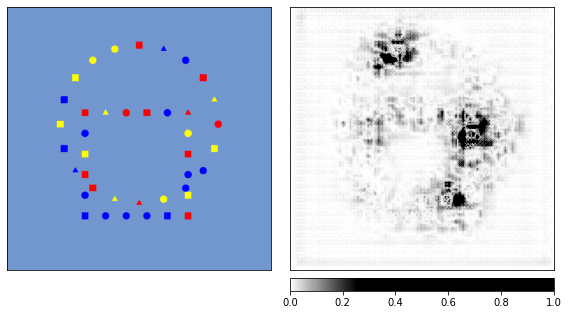

In [12]:
torch.manual_seed(0)
np.random.seed(0)
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([img * 0, img * 1])

attributions_gs = gradient_shap.attribute(img,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=clss)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [13]:
img, clss = get_img(2345)
img = img.unsqueeze(0).to(device)
output = model(img)
output = F.softmax(output, dim=1)
print(torch.topk(output,1))
print(clss)

torch.return_types.topk(
values=tensor([[1.0000]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[2]], device='cuda:0'))
2


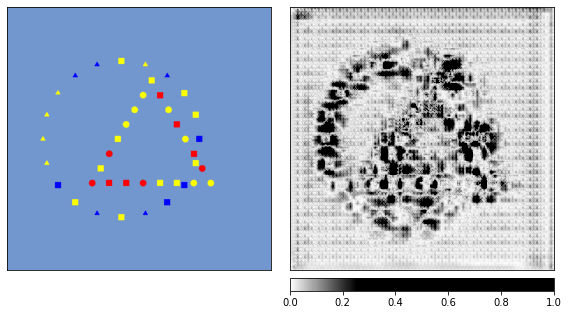

In [14]:
rand_img_dist = torch.cat([img * 0, img * 1])

attributions_gs = gradient_shap.attribute(img,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=clss)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

torch.return_types.topk(
values=tensor([[1.]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[2]], device='cuda:0'))
2


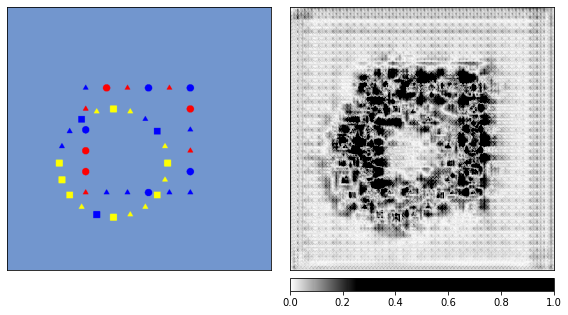

In [15]:
img, clss = get_img(2355)
img = img.unsqueeze(0).to(device)
output = model(img)
output = F.softmax(output, dim=1)
print(torch.topk(output,1))
print(clss)
rand_img_dist = torch.cat([img * 0, img * 1])

attributions_gs = gradient_shap.attribute(img,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=clss)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

torch.return_types.topk(
values=tensor([[1.0000]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[1]], device='cuda:0'))
1


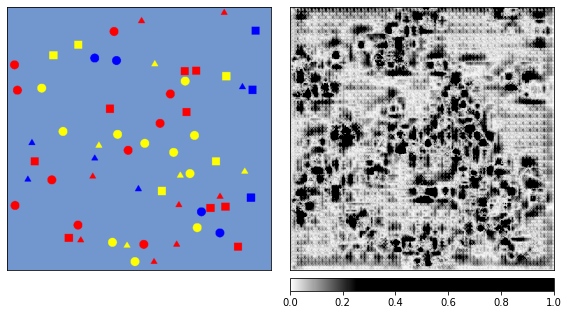

In [16]:
img, clss = get_img(1355)
img = img.unsqueeze(0).to(device)
output = model(img)
output = F.softmax(output, dim=1)
print(torch.topk(output,1))
print(clss)
rand_img_dist = torch.cat([img * 0, img * 1])

attributions_gs = gradient_shap.attribute(img,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=clss)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)